# **Protocolo de teleportación** (Qiskit vs Pennylane)
*Universidad Nacional Autónoma de México*
### Creado por: **Sebastián González Juárez**

In [ ]:
!pip install pennylane --quiet
!pip install qiskit --quiet

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.quantum_info import Statevector
import pennylane as qml

## **Qiskit.**

In [ ]:
def print_sv(label, sv):
    print("\n" + "="*60)
    print(label)
    print("="*60)
    amps = np.asarray(sv, dtype=complex).ravel()
    basis = [f"{i:03b}" for i in range(8)]  # ¡Esto es |q2 q1 q0>!
    for b, a in zip(basis, amps):
        if abs(a) > 1e-12:
            print(f"|{b}>  (|q2 q1 q0>) : {a.real:+.6f}{a.imag:+.6f}j")

In [ ]:
# Paso 0: preparar |+> en q0 y EPR en (q1,q2)
prep = QuantumCircuit(3)
prep.h(0)
prep.h(1); prep.cx(1, 2)
sv0 = Statevector.from_instruction(prep)
print(prep.draw("text"))
print_sv("Estado |Psi_0>", sv0)

     ┌───┐     
q_0: ┤ H ├─────
     ├───┤     
q_1: ┤ H ├──■──
     └───┘┌─┴─┐
q_2: ─────┤ X ├
          └───┘

Estado |Psi_0>
|000>  (|q2 q1 q0>) : +0.500000+0.000000j
|001>  (|q2 q1 q0>) : +0.500000+0.000000j
|110>  (|q2 q1 q0>) : +0.500000+0.000000j
|111>  (|q2 q1 q0>) : +0.500000+0.000000j


In [ ]:
# Paso 1: CNOT(q0->q1)
c1 = prep.copy()
c1.cx(0, 1)
sv1 = Statevector.from_instruction(c1)
print(c1.draw("text"))
print_sv("Estado |Psi_1> (tras CNOT q0->q1)", sv1)

     ┌───┐          
q_0: ┤ H ├───────■──
     ├───┤     ┌─┴─┐
q_1: ┤ H ├──■──┤ X ├
     └───┘┌─┴─┐└───┘
q_2: ─────┤ X ├─────
          └───┘     

Estado |Psi_1> (tras CNOT q0->q1)
|000>  (|q2 q1 q0>) : +0.500000+0.000000j
|011>  (|q2 q1 q0>) : +0.500000+0.000000j
|101>  (|q2 q1 q0>) : +0.500000+0.000000j
|110>  (|q2 q1 q0>) : +0.500000+0.000000j


In [ ]:
# Paso 2: H en q0
c2 = c1.copy()
c2.h(0)
sv2 = Statevector.from_instruction(c2)
print(c2.draw("text"))
print_sv("Estado |Psi_2> (tras H en q0)", sv2)

     ┌───┐          ┌───┐
q_0: ┤ H ├───────■──┤ H ├
     ├───┤     ┌─┴─┐└───┘
q_1: ┤ H ├──■──┤ X ├─────
     └───┘┌─┴─┐└───┘     
q_2: ─────┤ X ├──────────
          └───┘          

Estado |Psi_2> (tras H en q0)
|000>  (|q2 q1 q0>) : +0.353553+0.000000j
|001>  (|q2 q1 q0>) : +0.353553+0.000000j
|010>  (|q2 q1 q0>) : +0.353553+0.000000j
|011>  (|q2 q1 q0>) : -0.353553+0.000000j
|100>  (|q2 q1 q0>) : +0.353553+0.000000j
|101>  (|q2 q1 q0>) : -0.353553+0.000000j
|110>  (|q2 q1 q0>) : +0.353553+0.000000j
|111>  (|q2 q1 q0>) : +0.353553+0.000000j


In [ ]:
# --- Post-selección (q0,q1)=01 y Bob pre/post corrección ---
# Qiskit: reshape como (q2,q1,q0); para (q0,q1)=01 -> índices [:, 1, 0]
T_q2q1q0 = np.asarray(sv2, dtype=complex).reshape(2, 2, 2)
bob_unnorm = T_q2q1q0[:, 1, 0]                 # vector sobre q2
p01 = float(np.vdot(bob_unnorm, bob_unnorm).real)
bob_pre = bob_unnorm / np.sqrt(p01)
print("\n--- Post-selección (Alice=01) ---")
print("p(01) =", p01)
print("Bob PRE-corrección (vector):", bob_pre)


--- Post-selección (Alice=01) ---
p(01) = 0.2499999999999999
Bob PRE-corrección (vector): [0.70710678+0.j 0.70710678+0.j]


In [ ]:
# Corrección para 01: aplicar X a Bob
X = np.array([[0,1],[1,0]], dtype=complex)
bob_post = X @ bob_pre
print("Bob POST-corrección (aplicando X):", bob_post)

Bob POST-corrección (aplicando X): [0.70710678+0.j 0.70710678+0.j]


In [ ]:
# --- Circuito completo con medidas y condicionales (moderno: if_test) ---
qc = QuantumCircuit(3, 3)
qc.h(0)
qc.h(1); qc.cx(1, 2)
qc.cx(0, 1); qc.h(0)
qc.measure(0, 0); qc.measure(1, 1)
with qc.if_test((0, 1)):   # si c0==1 -> Z
    qc.z(2)
with qc.if_test((1, 1)):   # si c1==1 -> X
    qc.x(2)
qc.measure(2, 2)
print("\n--- Circuito completo con medidas y correcciones ---")
print(qc.draw("text"))


--- Circuito completo con medidas y correcciones ---
     ┌───┐          ┌───┐┌─┐                                                   »
q_0: ┤ H ├───────■──┤ H ├┤M├───────────────────────────────────────────────────»
     ├───┤     ┌─┴─┐└┬─┬┘└╥┘                                                   »
q_1: ┤ H ├──■──┤ X ├─┤M├──╫────────────────────────────────────────────────────»
     └───┘┌─┴─┐└───┘ └╥┘  ║   ┌──────  ┌───┐ ───────┐   ┌──────  ┌───┐ ───────┐»
q_2: ─────┤ X ├───────╫───╫───┤ If-0  ─┤ Z ├  End-0 ├───┤ If-0  ─┤ X ├  End-0 ├»
          └───┘       ║   ║   └──╥───  └───┘ ───────┘   └──╥───  └───┘ ───────┘»
                      ║   ║ ┌────╨────┐               ┌────╨────┐              »
c: 3/═════════════════╩═══╩═╡ c_0=0x1 ╞═══════════════╡ c_1=0x1 ╞══════════════»
                      1   0 └─────────┘               └─────────┘              »
«         
«q_0: ────
«         
«q_1: ────
«      ┌─┐
«q_2: ─┤M├
«      └╥┘
«c: 3/══╩═
«       2 


## **PennyLane**

In [ ]:
def print_sv(label, st):
    print("\n" + "="*60)
    print(label, "(base |q0 q1 q2>)")
    print("="*60)
    amps = np.asarray(st, dtype=complex).ravel()
    basis = [f"{i:03b}" for i in range(8)]  # aquí es |q0 q1 q2> (orden de wires)
    for b, a in zip(basis, amps):
        if abs(a) > 1e-12:
            print(f"|{b}> : {a.real:+.6f}{a.imag:+.6f}j")

In [ ]:
dev = qml.device("default.qubit", wires=3, shots=None)

In [ ]:
def prep():
    qml.Hadamard(0)        # |+> en q0
    qml.Hadamard(1); qml.CNOT([1,2])  # EPR (q1,q2)

def step1():
    prep()
    qml.CNOT([0,1])

def step2():
    step1()
    qml.Hadamard(0)

In [ ]:
print("\n--- Circuitos ---")
print("Paso 0:\n", qml.draw(prep)())
print("\nPaso 1:\n", qml.draw(step1)())
print("\nPaso 2:\n", qml.draw(step2)())


--- Circuitos ---
Paso 0:
 0: ──H────┤  
1: ──H─╭●─┤  
2: ────╰X─┤  

Paso 1:
 0: ──H────╭●─┤  
1: ──H─╭●─╰X─┤  
2: ────╰X────┤  

Paso 2:
 0: ──H────╭●──H─┤  
1: ──H─╭●─╰X────┤  
2: ────╰X───────┤  


In [ ]:
@qml.qnode(dev)
def psi0(): prep();  return qml.state()
@qml.qnode(dev)
def psi1(): step1(); return qml.state()
@qml.qnode(dev)
def psi2(): step2(); return qml.state()

In [ ]:
st0 = psi0(); print_sv("Estado |Psi_0>", st0)
st1 = psi1(); print_sv("Estado |Psi_1>", st1)
st2 = psi2(); print_sv("Estado |Psi_2>", st2)


Estado |Psi_0> (base |q0 q1 q2>)
|000> : +0.500000+0.000000j
|011> : +0.500000+0.000000j
|100> : +0.500000+0.000000j
|111> : +0.500000+0.000000j

Estado |Psi_1> (base |q0 q1 q2>)
|000> : +0.500000+0.000000j
|011> : +0.500000+0.000000j
|101> : +0.500000+0.000000j
|110> : +0.500000+0.000000j

Estado |Psi_2> (base |q0 q1 q2>)
|000> : +0.353553+0.000000j
|001> : +0.353553+0.000000j
|010> : +0.353553+0.000000j
|011> : +0.353553+0.000000j
|100> : +0.353553+0.000000j
|101> : -0.353553+0.000000j
|110> : -0.353553+0.000000j
|111> : +0.353553+0.000000j


In [ ]:
# Post-selección (q0,q1)=01 => índice [0,1,:] porque wires=(q0,q1,q2)
T = np.asarray(st2, dtype=complex).reshape(2,2,2)  # (q0,q1,q2)
bob_unnorm = T[0, 1, :]
p01 = float(np.vdot(bob_unnorm, bob_unnorm).real)
bob_pre = bob_unnorm / np.sqrt(p01)
X = np.array([[0,1],[1,0]], dtype=complex)
bob_post = X @ bob_pre

In [ ]:
print("\n--- Post-selección (Alice=01) ---")
print("p(01) =", p01)
print("Bob PRE-corrección (vector):", bob_pre)
print("Bob POST-corrección (aplicando X):", bob_post)


--- Post-selección (Alice=01) ---
p(01) = 0.2499999999999999
Bob PRE-corrección (vector): [0.70710678+0.j 0.70710678+0.j]
Bob POST-corrección (aplicando X): [0.70710678+0.j 0.70710678+0.j]


## **Texto**

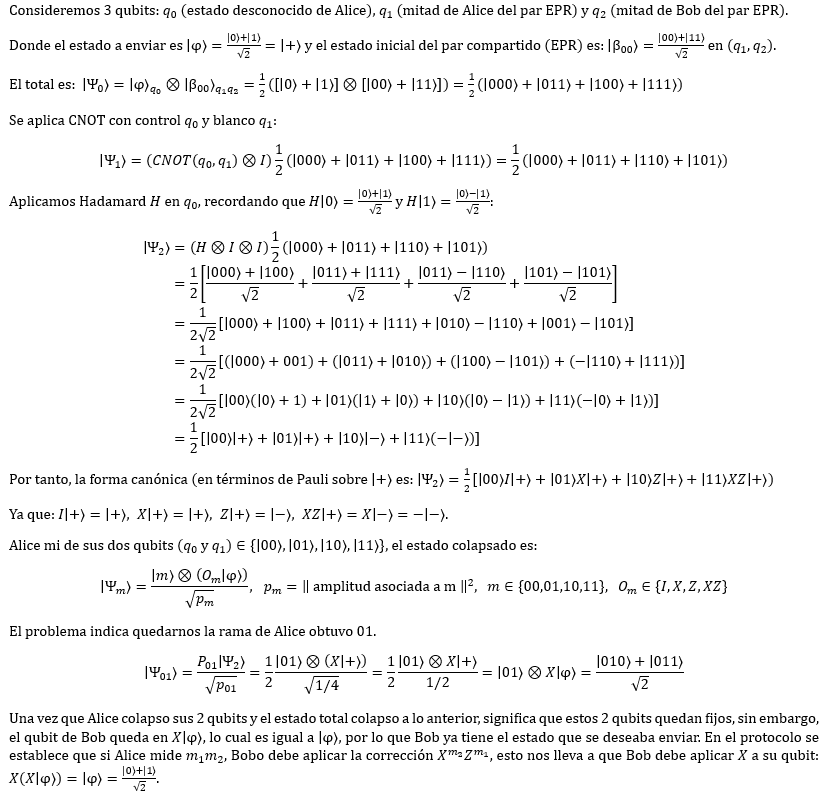